# WP1 - Anomaly subgraph extraction: Finding anomalies

In [129]:
import py2neo
import pandas as pd
import numpy as np
from spot import bidSPOT, dSPOT,  SPOT
import traceback
import networkx as nx
from datetime import datetime, timedelta

In [107]:
#graph = py2neo.Graph("bolt://192.168.1.185:7687", auth=("neo4j", ""))
# TODO. put this into neo4j again

graph = nx.read_graphml("../data/causality_chi2.graphml")
graph = graph.to_undirected()

c:\Users\andrea\.conda\envs\spatiotemporal\lib\site-packages\networkx\readwrite\graphml.py:1031: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
c:\Users\andrea\.conda\envs\spatiotemporal\lib\site-packages\networkx\readwrite\graphml.py:1031: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
c:\Users\andrea\.conda\envs\spatiotemporal\lib\site-packages\networkx\readwrite\graphml.py:1031: UserWarning: No key type for id causal. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
c:\Users\andrea\.conda\envs\spatiotemporal\lib\site-packages\networkx\readwrite\graphml.py:1031: UserWarning: No key type for id label. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")


In [ ]:
full_data = pd.read_csv('../data/loadtest-timestamp.csv')
full_data[['Date', 'Time']] = full_data['Time'].str.split(" ", expand=True)
full_data = full_data.sort_values(by=['Date','Time'])
full_data

In [ ]:
# Prepare data
u_data = (full_data['Date'] == '2/17/2022')| (full_data['Date'] == '3/2/2022')
all_data = full_data[u_data]
# initial batch
u_init_data = (full_data['Date'] == '10/14/2021') | (full_data['Date'] == '10/20/2021')| (full_data['Date'] == '10/19/2021')
all_init_data = full_data[u_init_data]

csv_nodes = full_data.columns.drop(['Date', 'Time', 'Unnamed: 0'])
print("Node names from data csv: ", sorted(csv_nodes))
# graph_nodes = [node['id'] for node in graph.nodes.match().all()]
graph_nodes = [node[1]['id'] for node in graph.nodes.data()]
print("Node names from graph: ", sorted(graph_nodes))
print("Nodes in graph but not in data csv: ", sorted(set(graph_nodes) - set(csv_nodes)))
print("Nodes in data csv but not in graph: ", sorted(set(csv_nodes) - set(graph_nodes)))
for column_name in csv_nodes:
    init_data = all_init_data[column_name].to_numpy()
    data = all_data[column_name].to_numpy()

    try:
        q = 1e-5  			# risk parameter
        s = SPOT(q)  		# SPOT object
        s.fit(init_data,data) 	# data import
        s.initialize(verbose=False) 		# initialization step
        results = s.run() 	# run
        #s.plot(results) 	# plot
        alarms = results["alarms"]
        print(column_name, alarms)
        #node = graph.nodes.match(id=column_name).first()
        node = [n for n in graph.nodes.data() if n[1]["id"] == column_name][0]
        if len(alarms) > 0:
            print(node)
            print("had an anomaly")
            print(full_data.iloc[alarms[0]])
            node[1]["anomaly"] = True
            #print(all_data.iloc[alarms][['Date', 'Time']])
            anomaly_timestamps = [" ".join(all_data.iloc[alarm][['Date', 'Time']]) for alarm in alarms]
            node[1]["anomaly_timestamps"] = anomaly_timestamps
            #graph.push(node)
        else:
            node[1]["anomaly"] = False
            # graph.push(node)
    except Exception:
            print(traceback.format_exc())


In [ ]:
nx.write_graphml(graph, "../data/causality_anomaly_timestamps.graphml")

In [110]:
remove_edges = [e for e in graph.edges(data=True) if e[2].get('causal')!='true']
graph.remove_edges_from(remove_edges)


In [111]:
graph.nodes.data()

NodeDataView({'n0': {'labels': ':Node', 'id': 'carts', 'anomaly': True, 'anomaly_timestamps': ['2/17/2022 20:44', '2/17/2022 21:26', '3/2/2022 11:56', '3/2/2022 11:57', '3/2/2022 11:58', '3/2/2022 11:59', '3/2/2022 12:00', '3/2/2022 12:01', '3/2/2022 12:02', '3/2/2022 12:03', '3/2/2022 12:12', '3/2/2022 12:13', '3/2/2022 12:14', '3/2/2022 12:15', '3/2/2022 12:19', '3/2/2022 12:20', '3/2/2022 12:21', '3/2/2022 12:22', '3/2/2022 12:23', '3/2/2022 12:24', '3/2/2022 12:25', '3/2/2022 15:35', '3/2/2022 15:53', '3/2/2022 15:54', '3/2/2022 15:55', '3/2/2022 15:56', '3/2/2022 15:57', '3/2/2022 15:58', '3/2/2022 15:59', '3/2/2022 16:00', '3/2/2022 16:46', '3/2/2022 17:54', '3/2/2022 17:55', '3/2/2022 17:56', '3/2/2022 17:57', '3/2/2022 17:58', '3/2/2022 17:59', '3/2/2022 18:00', '3/2/2022 18:01', '3/2/2022 18:48', '3/2/2022 19:49', '3/2/2022 19:50', '3/2/2022 19:51', '3/2/2022 19:52']}, 'n1': {'labels': ':Node', 'id': 'user', 'anomaly': False}, 'n2': {'labels': ':Node', 'id': 'user-db'}, 'n3': 

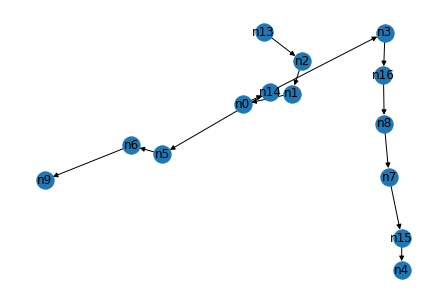

In [112]:
frontend_node = [n for n in graph.nodes.data() if n[1]["id"] == "front-end"][0]
anomaly_graph0 = nx.dfs_tree(graph, frontend_node[0])
nx.draw(anomaly_graph0, with_labels=True)

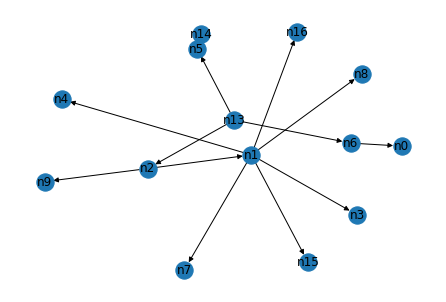

In [77]:
anomaly_graph0 = nx.bfs_tree(graph, frontend_node[0])
nx.draw(anomaly_graph0, with_labels=True)

In [74]:
list(nx.dfs_successors(graph, frontend_node[0]))

['n13', 'n2', 'n1', 'n0', 'n14', 'n3', 'n16', 'n8', 'n7', 'n15', 'n5', 'n6']

In [78]:
list(nx.bfs_successors(graph, frontend_node[0]))

[('n13', ['n2', 'n5', 'n6']),
 ('n2', ['n1', 'n9']),
 ('n5', ['n14']),
 ('n6', ['n0']),
 ('n1', ['n16', 'n3', 'n4', 'n7', 'n8', 'n15'])]

Next node
{'labels': ':Node', 'id': 'user-db'}
{'labels': ':Node', 'id': 'orders-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022 12:13', '3/2/2022 13:22', '3/2/2022 13:23', '3/2/2022 17:39', '3/2/2022 19:41']}
{'labels': ':Node', 'id': 'carts-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022 13:22', '3/2/2022 13:23']}
[('n5', '03/02/2022 13:23'), ('n6', '03/02/2022 13:23')]
Next node
{'labels': ':Node', 'id': 'orders', 'anomaly': True, 'anomaly_timestamps': ['2/17/2022 20:45', '2/17/2022 21:27', '3/2/2022 11:53', '3/2/2022 11:54', '3/2/2022 11:55', '3/2/2022 11:56', '3/2/2022 11:57', '3/2/2022 11:58', '3/2/2022 12:10', '3/2/2022 12:11', '3/2/2022 12:13', '3/2/2022 12:16', '3/2/2022 15:50', '3/2/2022 15:51', '3/2/2022 15:52', '3/2/2022 15:53', '3/2/2022 15:54', '3/2/2022 15:55', '3/2/2022 17:51', '3/2/2022 17:52', '3/2/2022 17:53', '3/2/2022 17:54', '3/2/2022 17:55', '3/2/2022 17:56', '3/2/2022 19:49', '3/2/2022 19:50', '3/2/2022 19:51']}
{'labels': ':Node', 'id': 'user-db'}

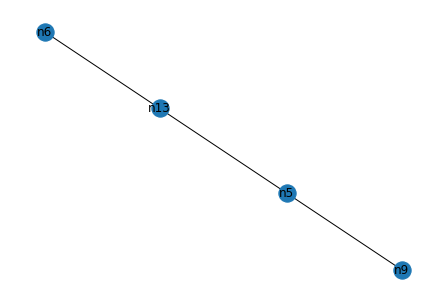

In [146]:
MAXLAG = 2
DATETIME_FORMAT = "%m/%d/%Y %H:%M"

def propagation_timestamp_next_node(current_node, neighbor, nodes_to_visit):
    if neighbor in nodes_to_visit:
        return None
    print(graph.nodes[neighbor])
    neighbor_data = graph.nodes[neighbor]
    if not neighbor_data.get("anomaly"):
        return None
    current_timestamp = G.nodes[current_node]["propagation_timestamp"]
    current_timestamp = datetime.strptime(current_timestamp, DATETIME_FORMAT)
    neighbor_anomaly_timestamps = np.array([datetime.strptime(timestamp, DATETIME_FORMAT) for timestamp in neighbor_data["anomaly_timestamps"]])
    max_propagation_timestamp = None
    
    time_diff = neighbor_anomaly_timestamps - current_timestamp
    propagation_timestamps = neighbor_anomaly_timestamps[np.logical_and((timedelta(minutes=0) <= time_diff), (time_diff <= timedelta(minutes=MAXLAG)))]
    if not len(propagation_timestamps):
        return None
    max_propagation_timestamp = datetime.strftime(np.max(propagation_timestamps), DATETIME_FORMAT)
    return max_propagation_timestamp
    



G=nx.Graph()
G.add_node(frontend_node[0], propagation_timestamp='3/2/2022 13:22')
nodes_to_visit = [frontend_node[0]]
for node in nodes_to_visit:
    #current_timestamp =
    #print(node)
    potential_next_nodes = []
    print("Next node")
    for n in list(graph.neighbors(node)):
        propagation_timestamp = propagation_timestamp_next_node(node, n, nodes_to_visit)
        if propagation_timestamp is not None:
            potential_next_nodes.append((n, propagation_timestamp))
    
    if len(potential_next_nodes) > 0:
        if np.random.choice([0, 1]):
            # bfs way
            next_nodes = potential_next_nodes
        else:
            # dfs way
            next_nodes = [potential_next_nodes[np.random.choice(len(potential_next_nodes))]]
            
        nodes_to_visit += [n for n, timestamp in next_nodes]
        for next_node, p_timestamp in next_nodes:
            G.add_node(next_node, propagation_timestamp=p_timestamp)
            G.add_edge(node, next_node, propagation_timestamp=p_timestamp)
        print(next_nodes)
nx.draw(G, with_labels=True)

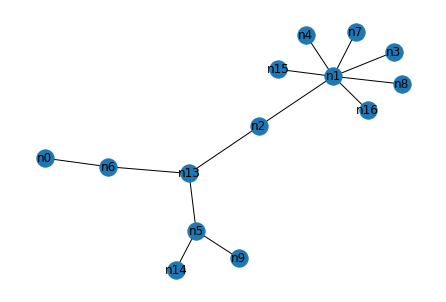

In [162]:
MAXLAG = 2

G=nx.Graph()
G.add_node(frontend_node[0])
# idea for timestep sampling
time=0
nodes_to_visit = [frontend_node[0]]
for node in nodes_to_visit:
    #current_timestamp =
    #print(node)
    potential_next_nodes = []
    potential_next_nodes = [n for n in list(graph.neighbors(node)) if not n in nodes_to_visit]
    
    if len(potential_next_nodes) > 0:
        if np.random.choice([0, 1]):
            # bfs way
            next_nodes = potential_next_nodes
        else:
            # dfs way
            next_nodes = [potential_next_nodes[np.random.choice(len(potential_next_nodes))]]
            
        nodes_to_visit += next_nodes
        for next_node in next_nodes:
            G.add_node(next_node)
            G.add_edge(node, next_node, timestamp=time)
        time +=1
nx.draw(G, with_labels=True)

In [163]:
nx.to_pandas_edgelist(G)

,source,target,timestamp
0,n13,n2,0
1,n13,n5,0
2,n13,n6,0
3,n2,n1,1
4,n5,n14,2
5,n5,n9,2
6,n6,n0,3
7,n1,n16,4
8,n1,n3,4
9,n1,n4,4


In [119]:
print(frontend_node[1]["anomaly_timestamps"])

['3/2/2022 11:50', '3/2/2022 13:22', '3/2/2022 15:47', '3/2/2022 17:48']


In [66]:
list(graph['n13'])

['n2', 'n5', 'n6']

In [67]:
print([graph.nodes[node] for node in list(graph.neighbors(frontend_node[0]))])

[{'labels': ':Node', 'id': 'user-db'}, {'labels': ':Node', 'id': 'orders-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022;12:13', '3/2/2022;13:22', '3/2/2022;13:23', '3/2/2022;17:39', '3/2/2022;19:41']}, {'labels': ':Node', 'id': 'carts-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022;13:22', '3/2/2022;13:23']}]
